# Install necessary packages

In [ ]:
pip install layoutparser

In [ ]:
!pip install pyyaml==5.1

import torch
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
# Install detectron2 that matches the above pytorch version
# See https://detectron2.readthedocs.io/tutorials/install.html for instructions
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/$CUDA_VERSION/torch$TORCH_VERSION/index.html
# If there is not yet a detectron2 release that matches the given torch + CUDA version, you need to install a different pytorch.

# exit(0)  # After installation, you may need to "restart runtime" in Colab. This line can also restart runtime

In [ ]:
pip install "layoutparser[layoutmodels]" # Install DL layout model toolkit 

In [ ]:
pip install "layoutparser[ocr]" # Install OCR toolkit

In [ ]:
!sudo apt install tesseract-ocr

In [ ]:
pip install pdf2image

In [ ]:
!sudo apt-get install poppler

In [ ]:
pip install PyMuPDF

# Import packages

In [ ]:
import fitz
import layoutparser as lp
import cv2
import os
from PIL import Image
import pytesseract
import pandas as pd
import numpy as np
import tempfile
from os import listdir
from os.path import isfile, join


Code to convert PDF files to PNG for OCR. The images are stored in *temp* folder.

In [ ]:
def pdf_to_image(path):
  doc = fitz.open(path)  # open document
  dir_path = os.path.dirname(os.path.realpath(path))
  path = dir_path + '/temp'
  if not os.path.exists(path):
    os.mkdir(path)
  os.chdir(path)
  for page in doc:  # iterate through the pages
    pix = page.get_pixmap()  # render page to an image
    pix.save("page-%i.png" % page.number)  # store image as a PNG
  return path

Specify the path to pdf by editing the *pdf_path* variable

In [ ]:
pdf_path = '/content/sample_data/New Age Deep Learning and Machine Learning (1).pdf'
#page = pdf_page_counter('/content/sample_data/APOORVA BORDOLOI_resume_2nd_intern.pdf')
dir_path=pdf_to_image(pdf_path)
dir_path

'/content/sample_data/temp'

In [ ]:
onlyfiles = [f for f in listdir(dir_path) if isfile(join(dir_path, f))]
onlyfiles

['page-4.png', 'page-0.png', 'page-3.png', 'page-2.png', 'page-1.png']

Specify the path to image located in *temp* folder by editing the *path* variable

Use OpenCV's cv2 to convert BGR images to their RBG form.


In [ ]:
path='/content/sample_data/temp/page-1.png'
image = cv2.imread(path)
image = image[..., ::-1]

# Model Building
Fetch pre-trained deep learning models for Detectron2.For all the supported model, please check the Model Zoo Page: https://layout-parser.readthedocs.io/en/latest/notes/modelzoo.html

We are using a model pre-trained on PubLayNet dataset. This dataset was originally created for document layout analysis. But since it contains large number of annotated images of various scholalry journals with labels such as "text", "list", "title" etc, it's useful for our use-case.

In [ ]:
model = lp.Detectron2LayoutModel('lp://PubLayNet/mask_rcnn_X_101_32x8d_FPN_3x/config', 
                                 extra_config=["MODEL.ROI_HEADS.SCORE_THRESH_TEST", 0.8],
                                 label_map={0: "Text", 1: "Title", 2: "List", 3:"Table", 4:"Figure"})
#Using the mask_rcnn_X_101_32x8d_FPN_3x model as it’s trained on the whole training set. A ~15% improvement is seen using the model.

In [ ]:
layout = model.detect(image)

/usr/local/lib/python3.7/dist-packages/detectron2/structures/image_list.py:88: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  max_size = (max_size + (stride - 1)) // stride * stride



In [ ]:
color_map = {
'Text': 'red',
'Title': 'blue',
'List': 'green',
'Table': 'purple',
'Figure': 'pink',
}

## Show bounding boxes (Step 1)

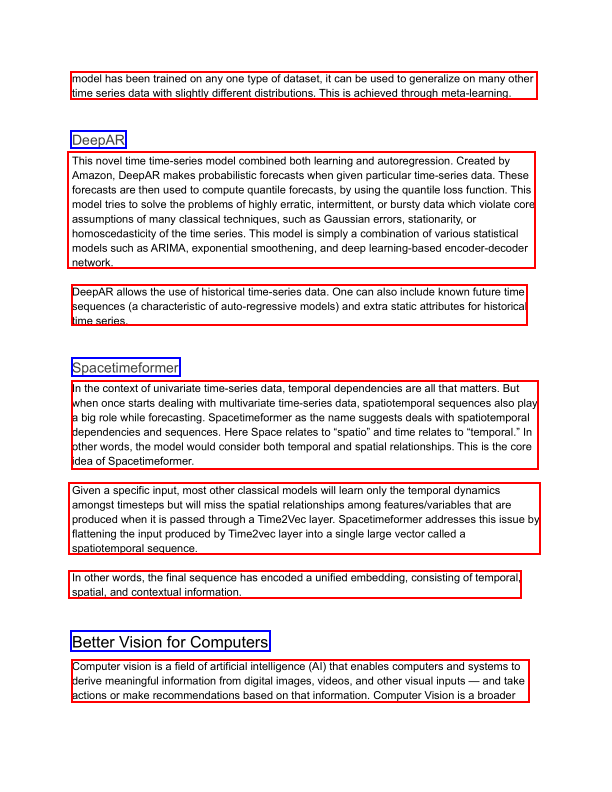

In [ ]:
lp.draw_box(image, layout, box_width=2, color_map=color_map)

## Optical Characted Recognition (Step 2)
We are only detecting text_blocks and title_blocks as of now.

In [ ]:
text_blocks = lp.Layout([b for b in layout if b.type=='Text'])
#figure_blocks = lp.Layout([b for b in layout if b.type=='Figure'])
title_blocks = lp.Layout([b for b in layout if b.type=='Title'])

Supports english text detection only.

In [ ]:
ocr_agent = lp.TesseractAgent(languages='eng') 

In [ ]:
for block in title_blocks:
    segment_image = (block
                       .pad(left=5, right=5, top=5, bottom=5)
                       .crop_image(image))
        # add padding in each image segment can help
        # improve robustness 
        
    text = ocr_agent.detect(segment_image)
    block.set(text=text, inplace=True)

Printing the titles

In [ ]:
for txt in title_blocks.get_texts():
    print(txt, end='\n---\n')

Better Vision for Computers

---
DeepAR

---
Spacetimeformer

---


In [ ]:
for block in text_blocks:
    segment_image = (block
                       .pad(left=5, right=5, top=5, bottom=5)
                       .crop_image(image))
        # add padding in each image segment can help
        # improve robustness 
        
    text = ocr_agent.detect(segment_image)
    block.set(text=text, inplace=True)

Printing actual text

In [ ]:
for txt in text_blocks.get_texts():
    print(txt, end='\n---\n')

Inthe context of univariate time-series data, temporal dependencies are ail that matters. But
When once starts dealing with multivariate time-series data, spatiotemporal sequences also play
a big role while forecasting. Spacetimeformer as the name suggests deals with spatiotemporal
dependencies and sequences. Here Space relates to “spatio” and time relates to “temporal.” In
‘other words, the model would consider both temporal and spatial relationships. Ths isthe core

idea of Spacetimeformer.

---
Given a specific input, most other classical models will lam only the temporal dynamics
amongst timesteps but will miss the spatial relationships among featuresivariables that are
produced when itis passed through a Time2Vec layer. Spacotimeformer addresses this issue by
flattening the input produced by Time2vec layer into a single large vector called a
‘spatiotemporal sequence.

---
This novel time time-series model combined both learning and autoregression. Created by
‘Amazon, DeepAAR mak

# Test Code (Don't Run)

In [ ]:
images = convert_from_bytes(open('FILE PATH', 'rb').read())

In [ ]:
images = np.array(images)

In [ ]:
#loop through each page
for image in images:
    ocr_agent = lp.TesseractAgent(language='eng')
    
    image = np.array(image)
    
    layout = model.detect(image)

    lp.draw_box(image, layout, box_width=3).show()
    # Show the detected layout of the input image